In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import discreteaction_pendulum
import random
from collections import namedtuple, deque
from matplotlib import pyplot as plt
import seaborn as sns


In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

class DQN(nn.Module):
    """
    Adapted from Pytorch official tutorial :
    https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.htmls
    
    """

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 64)
        self.layer2 = nn.Linear(64, 64)
        self.layer_output = nn.Linear(64, n_actions)

    def forward(self, x):
        x = F.tanh(self.layer1(x))
        x = F.tanh(self.layer2(x))
        return self.layer_output(x)



class ReplayMemory(object):
    """a cyclic buffer for replay"""
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def save(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

def decay_eps(k ,eps_init, eps_end, num_episodes):
    # max_steps_done = 100

    # interpolated_eps = (eps_end - eps_init)*k/(num_episodes*100) + eps_init
    # interpolated_eps = max(eps_end, eps_init*0.98)

    #Expoential decay:
    interpolated_eps = eps_end + (eps_init - eps_end) * np.exp(-1. * k / 1000)

    return interpolated_eps


def action(state, eps, n_actions, policy_net):
    """Pick an eps-greedy policy to balance exploration and exploitation"""
   
    if np.random.random() < eps:
        action = torch.tensor([[random.randrange(n_actions)]], dtype=torch.long)
    
    else:
        action = policy_net(state).max(1)[1].view(1, 1)

    return action


def update_weights(memory ,optimizer, policy_net, target_net, batch_size, GAMMA):
    if len(memory) < batch_size:
        return

    transitions = memory.sample(batch_size)
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    """
    non_final_mask is a Boolean tensor indicating whether the next state in the batch is not None
    non_final_next_states is a tensor containing all the non-final next states in the batch.
    state_batch is a tensor containing all the current states in the batch.
    action_batch is a tensor containing all the actions taken in the current states in the batch.
    reward_batch is a tensor containing all the rewards received in the current states in the batch.
    
    """
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(batch_size, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()
    

def train_network(n_actions, num_episodes, policy_net, target_net, \
                    optimizer, memory, env,  batch_size, eps_init, eps_end, GAMMA, target_update_frequency):

    reward_full = np.zeros(num_episodes)
    actions = []
    count = 0
    traj = []
    for episode in range(num_episodes):
        
        s = env.reset()
        s = torch.tensor(s, dtype=torch.float32).unsqueeze(0)
        traj.append(s)
        done = False
        k = 0
        
        while not done:
            eps = decay_eps(k , eps_init, eps_end, num_episodes)
            a = action(s, eps, n_actions, policy_net)
            actions.append(a)
            
            
            s_next, reward, done = env.step(a.item())
            
                
            reward = torch.tensor([reward])

            reward_full[episode] += reward * GAMMA**k
            # print(reward_full[episode])

            #append discounted reward to current EPISODE: each episode is associated with a single reward value

            k += 1
            s_next = torch.tensor(s_next, dtype=torch.float32).unsqueeze(0)
            memory.save(s, a, s_next, reward, done)
            # Move to the next state
            s = s_next

            # Update weights
            update_weights(memory ,optimizer, policy_net, target_net, batch_size, GAMMA)

            count+=1

            #synchronize weights of target_net and policy_net every 100 steps 
            if count % target_update_frequency == 0:
                target_net.load_state_dict(policy_net.state_dict())
                

    return policy_net, reward_full, actions, traj
  




In [22]:
def plot_policy(env, policy):
    theta = np.linspace(-np.pi, np.pi, 100)
    thetadot = np.linspace(-15, 15, 100)
    action = np.zeros([len(theta), len(thetadot)])
    
    for i in range(len(theta)): 
        for j in range(len(thetadot)): 
            s = torch.tensor([theta[i], thetadot[j]]).float()
            a = torch.argmax(policy(s)).detach()
            action[i,j] = env._a_to_u(a)
    
    fig2, ax2 = plt.subplots()
    c = ax2.contourf(theta, thetadot, action, alpha = .75)
    ax2.set_xlabel(r'$\theta$')
    ax2.set_ylabel(r'$\dot{\theta}$')
    cbar = fig2.colorbar(c)
    cbar.ax.set_ylabel(r'$\tau$')
    # fig2.savefig('./figures/policy.png')

In [ ]:

GAMMA = 0.95
eps_init = 1.0
eps_end = 0.1
num_episodes = 100

env = discreteaction_pendulum.Pendulum()
batch_size = 64
n_actions = env.num_actions
n_states = env.num_states

policy_net = DQN(n_states, n_actions)
target_net = DQN(n_states, n_actions)

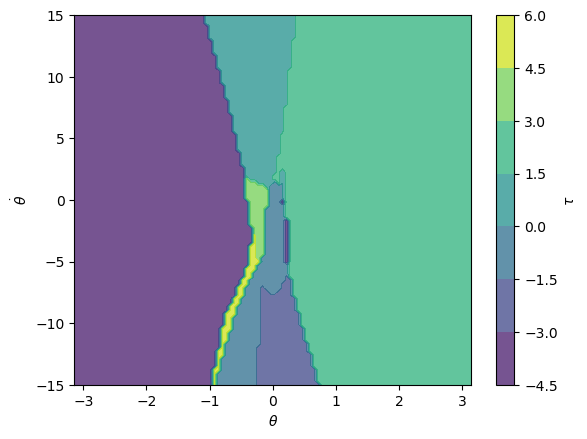

In [25]:
plot_policy(env,policy_net)

In [ ]:

target_net.load_state_dict(policy_net.state_dict()) #synchronize weights for initialization

# optimizer = optim.AdamW(policy_net.parameters(), lr = 1e-4, amsgrad=True)
optimizer = optim.RMSprop(policy_net.parameters(), lr=1e-4)
memory = ReplayMemory(int(1e6))

update_freq = 1000

policy_net, reward_Full ,actions_Full, traj= train_network(n_actions, num_episodes, policy_net, target_net, \
                                        optimizer, memory, env,  batch_size, eps_init, eps_end, GAMMA, \
                                        target_update_frequency = update_freq)




In [ ]:
torch.save(policy_net.state_dict(), "trained_policy_Apr1")

In [ ]:
policy_net.load_state_dict(torch.load("trained_policy_Apr1"))

<All keys matched successfully>

In [ ]:
policy_net

DQN(
  (layer1): Linear(in_features=2, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=64, bias=True)
  (layer_output): Linear(in_features=64, out_features=31, bias=True)
)

In [ ]:
actions_Full[0].item()

5

Text(0, 0.5, 'Tau')

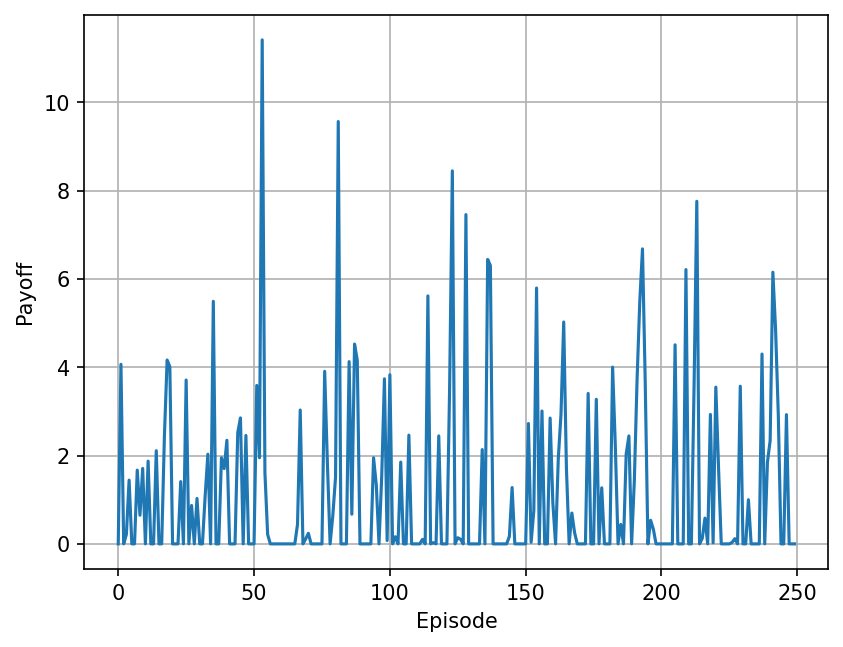

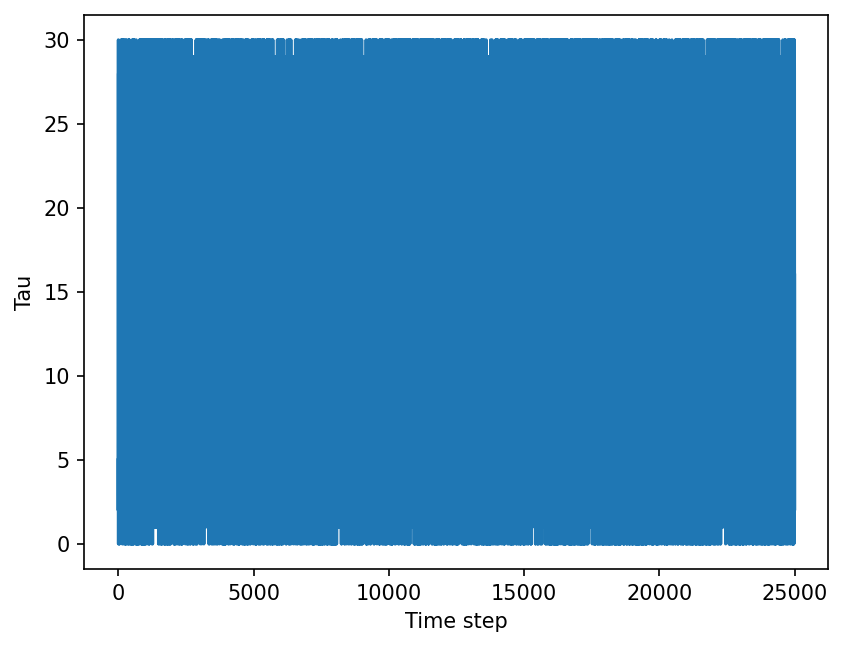

In [ ]:
"""Plot a learning curve"""
plt.figure(dpi=150)
plt.plot(reward_Full)
plt.xlabel('Episode')
plt.ylabel('Payoff')
plt.grid()
# plt.savefig('figures_trained/LearningCurve.png')

"""Plot a trained policy"""
plt.figure(dpi=150)
plt.plot([i.item() for i in actions_Full])
plt.xlabel('Time step')
plt.ylabel('Tau')
# plt.savefig('figures_trained/policy_heatmap.png')